In [3]:
#! shred -u setup_google_colab.py
#! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
#import setup_google_colab
#setup_google_colab.setup_week6()

shred: setup_google_colab.py: failed to open for writing: No such file or directory
--2020-01-30 23:10:46--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3636 (3.6K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.55K  --.-KB/s    in 0s      

2020-01-30 23:10:46 (90.1 MB/s) - ‘setup_google_colab.py’ saved [3636/3636]

**************************************************
captions_train-val2014.zip
**************************************************
train2014_sample.zip
**************************************************
train_img_embeds.pickle
**************************************************
train_img_fns.pickle
*****************

In [0]:
import sys
sys.path.append("..")
import grading
import download_utils

In [0]:
download_utils.link_all_keras_resources()

In [6]:
import tensorflow as tf
from tensorflow.contrib import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
L = keras.layers
K = keras.backend
import utils
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import grading_utils
import os
from keras_utils import reset_tf_session
import tqdm_utils

Using TensorFlow backend.


In [0]:
download_utils.link_week_6_resources()

In [0]:
IMG_SIZE = 299

In [0]:
def get_cnn_encoder():
    K.set_learning_phase(False) #keras.backend as K
    model = keras.applications.InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input

    model = keras.models.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

In [10]:
train_img_embeds = utils.read_pickle("train_img_embeds.pickle")
train_img_fns = utils.read_pickle("train_img_fns.pickle")
val_img_embeds = utils.read_pickle("val_img_embeds.pickle")
val_img_fns = utils.read_pickle("val_img_fns.pickle")
# check shapes
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(82783, 2048) 82783
(40504, 2048) 40504


In [11]:
list(filter(lambda x: x.endswith("_sample.zip"), os.listdir(".")))

['train2014_sample.zip', 'val2014_sample.zip']

In [12]:
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

# check shape
print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))

82783 82783
40504 40504


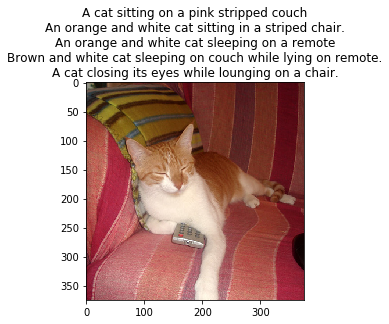

In [13]:
def show_trainig_example(train_img_fns, train_captions, example_idx=0):
    """
    You can change example_idx and see different images
    """
    zf = zipfile.ZipFile("train2014_sample.zip")
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = utils.decode_image_from_buf(zf.read(example))
    plt.imshow(utils.image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()
    
show_trainig_example(train_img_fns, train_captions, example_idx=142)

In [14]:
train_captions[:2]

[['A long dirt road going through a forest.',
  'A SCENE OF WATER AND A PATH WAY',
  'A sandy path surrounded by trees leads to a beach.',
  'Ocean view through a dirt road surrounded by a forested area. ',
  'dirt path leading beneath barren trees to open plains'],
 ['A group of zebra standing next to each other.',
  'This is an image of of zebras drinking',
  'ZEBRAS AND BIRDS SHARING THE SAME WATERING HOLE',
  'Zebras that are bent over and drinking water together.',
  'a number of zebras drinking water near one another']]

In [0]:
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

# split sentence into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_vocabulary(train_captions):

    from collections import Counter
    words = [word for captions in train_captions for sentence in captions for word in split_sentence(sentence) ]
    vocab = [k for k,v in Counter(words).items() if v >=5] + [PAD, UNK, START, END]
    return {token: index for index, token in enumerate(sorted(vocab))}
    
    
def caption_tokens_to_indices(captions, vocab):

    res = [[
            [vocab[START]] + [vocab.get(word, vocab[UNK]) for word in split_sentence(sentence)] + [vocab[END]] 
              for sentence in sentences] for sentences in captions]
    return res

In [16]:
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
print(len(vocab))

8769


In [0]:
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

In [0]:
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):

    if max_len == None:
        columns = max(map(len, batch_captions))
    else:
        columns  = min(max_len, max(map(len, batch_captions))) 
        
    matrix = []
    
    for row in batch_captions:
        matrix.append(row[:columns] + [pad_idx] * ((columns>len(row))*(columns-len(row))))
        
    matrix = np.array(matrix)
    return matrix

In [0]:
assert len(caption_tokens_to_indices(train_captions[:10], vocab)) == 10
assert len(caption_tokens_to_indices(train_captions[:5], vocab)) == 5

In [0]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [21]:
s = reset_tf_session()
tf.set_random_seed(42)

In [22]:
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab))
    
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    c0 = h0 =  img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds)) ### YOUR CODE HERE ###

    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    word_embeds =  word_embed(sentences[:,:-1]) ### YOUR CODE HERE ###
    
    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    # now we need to calculate token logits for all the hidden states
    
    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    flat_hidden_states =  tf.reshape(hidden_states,[-1,LSTM_UNITS]) ### YOUR CODE HERE ###

    # then, we calculate logits for next tokens using `token_logits` layer
    flat_token_logits =  token_logits(token_logits_bottleneck(flat_hidden_states)) ### YOUR CODE HERE ###
    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    flat_ground_truth = tf.reshape(sentences[:,1:],[-1]) ### YOUR CODE HERE ###

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    flat_loss_mask = tf.cast(tf.not_equal(flat_ground_truth,pad_idx), tf.float32) ### YOUR CODE HERE ###

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    loss =  tf.reduce_sum(tf.multiply(xent, flat_loss_mask)) / tf.reduce_sum(flat_loss_mask) ### YOUR CODE HERE ###

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

**Training loop**

In [0]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [0]:
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """
    idx = np.random.choice(images_embeddings.shape[0], batch_size)
    batch_image_embeddings = images_embeddings[idx] ### YOUR CODE HERE ###
    
    cap_idx = np.random.choice(5, batch_size)
    
    batch_captions = []
    for i in range(batch_size):
        sample = indexed_captions[idx[i]][cap_idx[i]]
        batch_captions.append(sample)
    
    batch_captions_matrix = batch_captions_to_matrix(batch_captions, pad_idx, max_len) ### YOUR CODE HERE ###
    
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [0]:
batch_size = 64
n_epochs = 12
n_batches_per_epoch = 1000
n_validation_batches = 100  # how many batches are used for validation after each epoch

In [0]:
# you can load trained weights here
# you can load "weights_{epoch}" and continue training
# uncomment the next line if you need to load weights
#saver.restore(s, os.path.abspath("weights"))

**Actual Training**

In [28]:
# actual training loop
MAX_LEN = 20  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        train_loss += s.run([decoder.loss, train_step], 
                            generate_batch(train_img_embeds, 
                                           train_captions_indexed, 
                                           batch_size, 
                                           MAX_LEN))[0]
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, os.path.abspath("weights_{}".format(epoch)))
    
print("Done!")

**************************************************
Training loss: 4.286193
Epoch: 0, train loss: 4.2861930449008945, val loss: 3.693553102016449
**************************************************
Training loss: 3.399725
Epoch: 1, train loss: 3.3997252218723295, val loss: 3.209359426498413
**************************************************
Training loss: 3.032739
Epoch: 2, train loss: 3.0327388987541197, val loss: 2.984347143173218
**************************************************
Training loss: 2.876488
Epoch: 3, train loss: 2.876488460302353, val loss: 2.868812379837036
**************************************************
Training loss: 2.780323
Epoch: 4, train loss: 2.7803231744766235, val loss: 2.8018763160705564
**************************************************
Training loss: 2.699758
Epoch: 5, train loss: 2.699758448600769, val loss: 2.763174569606781
Instructions for updating:
Use standard file APIs to delete files with this prefix.
***********************************************

In [29]:
# check that it's learnt something, outputs accuracy of next word prediction (should be around 0.5)
from sklearn.metrics import accuracy_score, log_loss

def decode_sentence(sentence_indices):
    return " ".join(list(map(vocab_inverse.get, sentence_indices)))

def check_after_training(n_examples):
    fd = generate_batch(train_img_embeds, train_captions_indexed, batch_size)
    logits = decoder.flat_token_logits.eval(fd)
    truth = decoder.flat_ground_truth.eval(fd)
    mask = decoder.flat_loss_mask.eval(fd).astype(bool)
    print("Loss:", decoder.loss.eval(fd))
    print("Accuracy:", accuracy_score(logits.argmax(axis=1)[mask], truth[mask]))
    for example_idx in range(n_examples):
        print("Example", example_idx)
        print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
        print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
        print("")

check_after_training(3)

Loss: 2.3297288
Accuracy: 0.5075445816186557
Example 0
Predicted: a man is a red shirt is jeans is a trick on a skateboard #END# #END# #END# #END# #END# #END#
Truth: a man in a blue shirt and jeans doing a trick on a skateboard #END# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 1
Predicted: a people trains are on to a other #END# a train light #END# #END# #END# #END# #END# #END# #END# #END#
Truth: two red trams are next to each other at a stop #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 2
Predicted: a dog bear sitting on a of a bed #END# a pillows #END# and and and and and and and
Truth: a teddy bear sitting on top of a bed between two pillows #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#



In [30]:
# save graph weights to file!
saver.save(s, "weights")

'weights'

In [31]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    saver.restore(s, "weights")  # keras applications corrupt our graph, so we restore trained weights
    
    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [None, IMG_SIZE, IMG_SIZE, 3], name='images')

    # get image embeddings
    img_embeds = encoder(input_images)

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    
    # current word index
    current_word = tf.placeholder('int32', [None], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)

    # apply lstm cell, get new lstm states
    new_c, new_h = decoder.lstm(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

INFO:tensorflow:Restoring parameters from weights


In [32]:
# look at how temperature works for probability distributions
# for high temperature we have more uniform distribution
_ = np.array([0.5, 0.4, 0.1])
for t in [0.01, 0.1, 1, 10, 100]:
    print(" ".join(map(str, _**(1/t) / np.sum(_**(1/t)))), "with temperature", t)

0.9999999997962965 2.0370359759195462e-10 1.2676505999700117e-70 with temperature 0.01
0.9030370433250645 0.09696286420394223 9.247099323648666e-08 with temperature 0.1
0.5 0.4 0.1 with temperature 1
0.35344772639219624 0.34564811360592396 0.3009041600018798 with temperature 10
0.33536728048099185 0.33461976434857876 0.3300129551704294 with temperature 100


In [0]:
# this is an actual prediction loop
def generate_caption(image, t=1, sample=False, max_len=20):
    """
    Generate caption for given image.
    if `sample` is True, we will sample next token from predicted probability distribution.
    `t` is a temperature during that sampling,
        higher `t` causes more uniform-like distribution = more chaos.
    """
    # condition lstm on the image
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})
    
    # current caption
    # start with only START token
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        
        # apply temperature
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

a baseball player swinging a bat at a ball


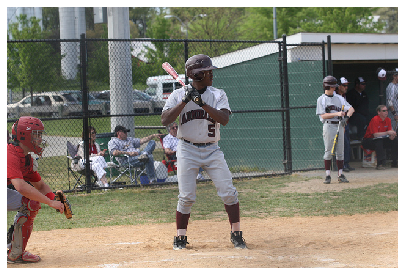

In [34]:
# look at validation prediction example
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

def show_valid_example(val_img_fns, example_idx=0):
    zf = zipfile.ZipFile("val2014_sample.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    apply_model_to_image_raw_bytes(zf.read(example))
    


a cat is sitting on a table next to a laptop


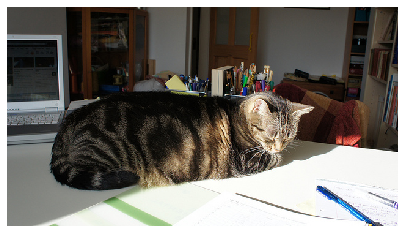

In [41]:
show_valid_example(val_img_fns, example_idx=120)

a picture of a kitchen with a refrigerator and a refrigerator


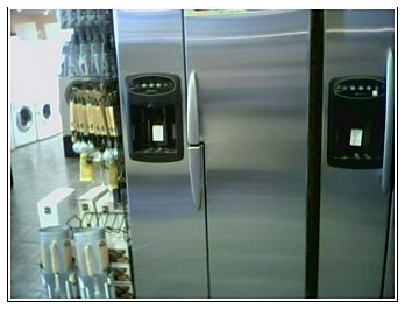

a group of people standing in a canal with a boat


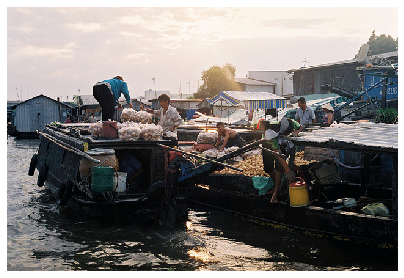

a man standing on a beach holding a surfboard


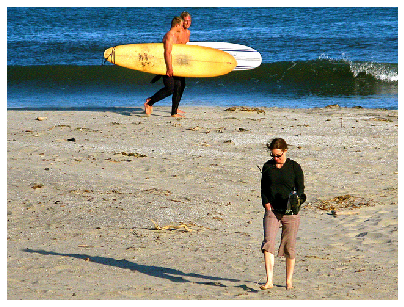

a beach with a lot of kites and people in the background


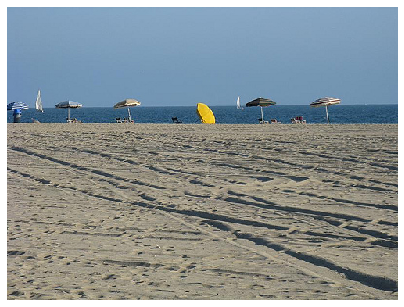

a room with a laptop and a tv in it


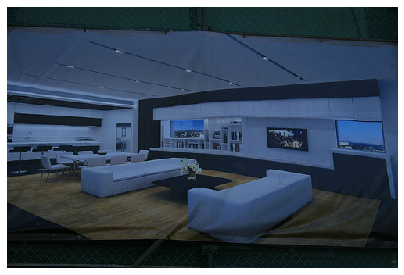

In [46]:
# sample more images from validation
for idx in np.random.choice(range(len(zipfile.ZipFile("val2014_sample.zip").filelist) - 1), 5):
    show_valid_example(val_img_fns, example_idx=idx)
    time.sleep(1)

In [0]:
! wget http://www.bijouxandbits.com/wp-content/uploads/2016/06/portal-cake-10.jpg

In [0]:
! wget https://cosmos-images2.imgix.net/file/spina/photo/20565/191010_nature.jpg

In [0]:
! wget https://d2ck0sxsjau14o.cloudfront.net/wp-content/uploads/2020/01/woman-in-nature-forest-happy-satisfied.jpg

In [0]:
! wget https://ctl.s6img.com/society6/img/EZM79C1IUBzFOVedhdDlZKciCm4/w_700/prints/~artwork/s6-original-art-uploads/society6/uploads/misc/8a88a9075af7434ab0447c837839eb60/~~/madala-ombre-colorful-prints.jpg?wait=0&attempt=0

In [0]:
! wget https://www.fccnn.com/incoming/3830206-91sb65-Sloth-from-Planet-Earth-II.jpg/alternates/BASE_LANDSCAPE/Sloth%20from%20Planet%20Earth%20II.jpg

In [0]:
! wget https://cdn.shopify.com/s/files/1/0078/8575/0369/products/Colorful_Owl_-_PAint_by_Diamonds_540x.jpg

In [0]:
! wget https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/screen-shot-2018-11-15-at-10-40-09-am-1542296443.png?resize=980:*

In [0]:
! wget https://img.zeit.de/politik/ausland/2019-02/kim-jong-un-donald-trump-gipfel-treffen/wide__820x461__desktop

In [0]:
! wget https://static.twentytwowords.com/cdn-cgi/image/width=1200,quality=85,fit=scale-down,format=auto,onerror=redirect/https://static.twentytwowords.com/wp-content/uploads/Weird-Pictures-That-Will-Make-You-Giggle-Despite-Your-Best-Intentions2.jpg

In [0]:
! wget https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/Football_iu_1996.jpg/1280px-Football_iu_1996.jpg

In [0]:
! wget https://cdn.mos.cms.futurecdn.net/wSKYGu98RCywrc8FZxmYBQ.jpg

In [0]:
! wget https://a57.foxnews.com/static.foxnews.com/foxnews.com/content/uploads/2019/12/931/524/horse.jpg?ve=1&tl=1

In [0]:
! wget https://ak2.picdn.net/shutterstock/videos/1018436752/thumb/9.jpg

In [0]:
! wget https://st2.depositphotos.com/5444644/8190/i/950/depositphotos_81901828-stock-photo-pretty-fitness-woman-jogging-in.jpg

In [0]:
! wget https://www.alpenpark-neuss.de/fileadmin/_processed_/4/e/csm_Gruppe_Party_2_888a701c2c.jpg

In [0]:
! wget https://content.jdmagicbox.com/comp/sangli/m9/9999px233.x233.121023103024.i8m9/catalogue/natural-photo-studio-pragati-colony-sangli-photo-studios-elm6ffa0qn.jpg

**Correct Prediction (Well, somewhat correct!)**

In [0]:
! wget https://cdn.fstoppers.com/styles/large-16-9/s3/lead/2019/11/9afbd16748b85ad4baee77b7c38f3237.jpg

a group of people standing around a table with a cake


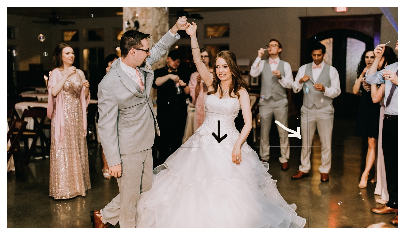

In [94]:
apply_model_to_image_raw_bytes(open("9afbd16748b85ad4baee77b7c38f3237.jpg", "rb").read())

a man and woman are standing in front of a large building


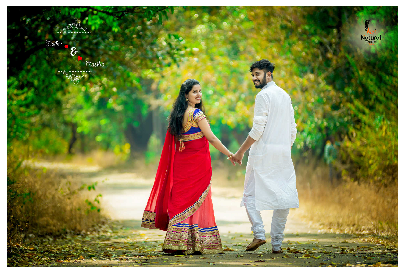

In [92]:
apply_model_to_image_raw_bytes(open("natural-photo-studio-pragati-colony-sangli-photo-studios-elm6ffa0qn.jpg", "rb").read())

a group of people sitting around a table with a cake


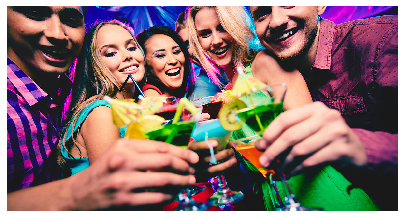

In [90]:
apply_model_to_image_raw_bytes(open("csm_Gruppe_Party_2_888a701c2c.jpg", "rb").read())

a woman holding a pink umbrella in front of a building


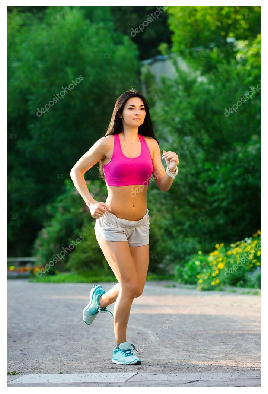

In [88]:
apply_model_to_image_raw_bytes(open("depositphotos_81901828-stock-photo-pretty-fitness-woman-jogging-in.jpg", "rb").read())

a man is playing frisbee in the grass


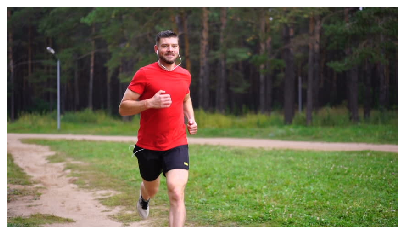

In [86]:
apply_model_to_image_raw_bytes(open("9.jpg", "rb").read())

a horse standing in a field next to a forest


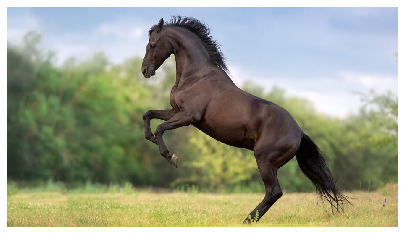

In [71]:
apply_model_to_image_raw_bytes(open("horse.jpg?ve=1", "rb").read())

a group of young men playing a game of soccer


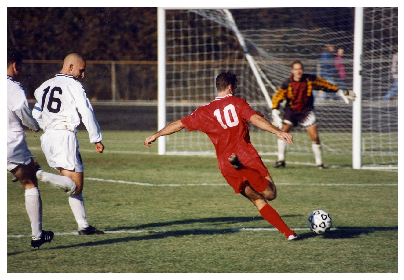

In [65]:
apply_model_to_image_raw_bytes(open("1280px-Football_iu_1996.jpg", "rb").read())

a cake with a fork and a knife on top


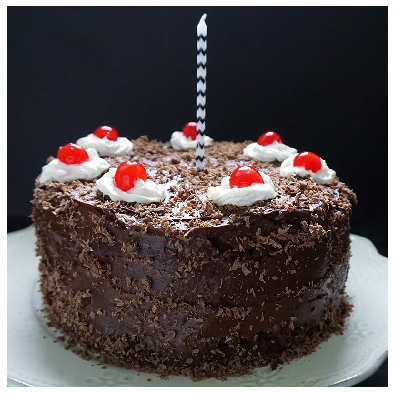

In [51]:
apply_model_to_image_raw_bytes(open("portal-cake-10.jpg", "rb").read())

a woman holding a cell phone in the air


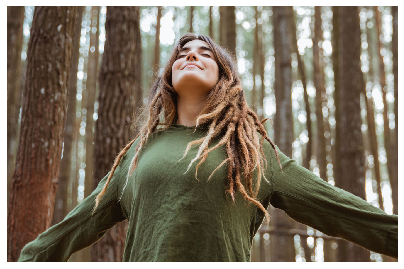

In [45]:
apply_model_to_image_raw_bytes(open("woman-in-nature-forest-happy-satisfied.jpg", "rb").read())

a man in a suit and tie standing next to a wall


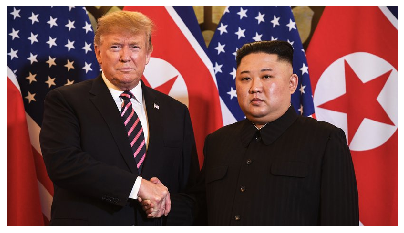

In [58]:
apply_model_to_image_raw_bytes(open("wide__820x461__desktop.1", "rb").read())

**Disasta!**

In [0]:
! wget https://static.toiimg.com/photo/67365546.cms

In [0]:
! wget https://i.ytimg.com/vi/llIGugo7qLw/maxresdefault.jpg

In [0]:
! wget https://cdn.cnn.com/cnnnext/dam/assets/180907121340-elon-musk-joe-rogan-smoking.jpg

a man in a dress shirt and a tie


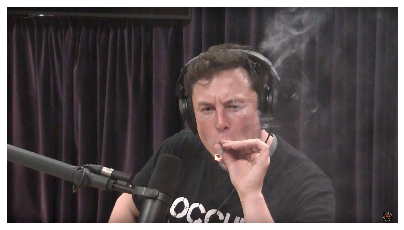

In [78]:
apply_model_to_image_raw_bytes(open("180907121340-elon-musk-joe-rogan-smoking.jpg", "rb").read())

a man holding a bunch of scissors in a store


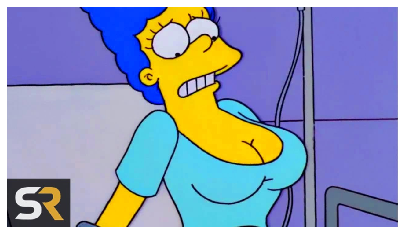

In [76]:
apply_model_to_image_raw_bytes(open("maxresdefault.jpg", "rb").read())

a group of people standing next to each other


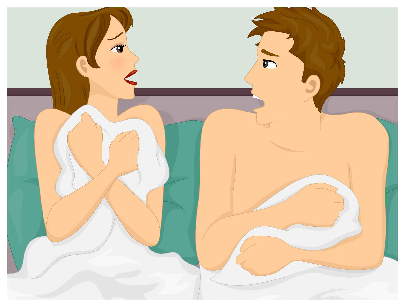

In [73]:
apply_model_to_image_raw_bytes(open("67365546.cms.1", "rb").read())

a woman holding a toothbrush in her mouth


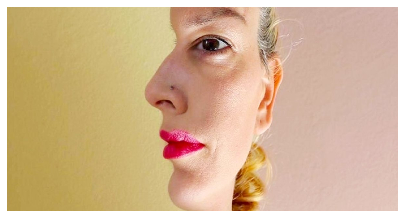

In [60]:
apply_model_to_image_raw_bytes(open("Weird-Pictures-That-Will-Make-You-Giggle-Despite-Your-Best-Intentions2.jpg", "rb").read())

a man in a helmet is jumping a skateboard


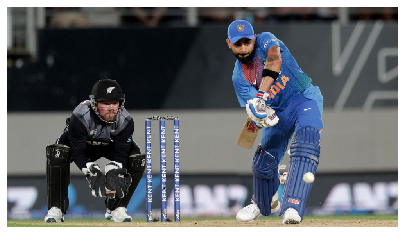

In [67]:
apply_model_to_image_raw_bytes(open("wSKYGu98RCywrc8FZxmYBQ.jpg", "rb").read())

a sign that is full of different colors


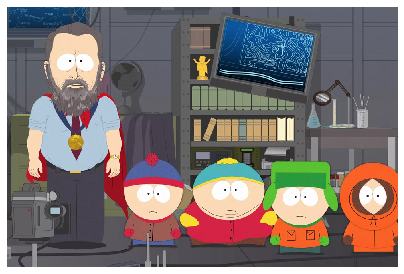

In [63]:
apply_model_to_image_raw_bytes(open("screen-shot-2018-11-15-at-10-40-09-am-1542296443.png?resize=980:*.1", "rb").read())

a yellow and white clock sitting on top of a wooden table


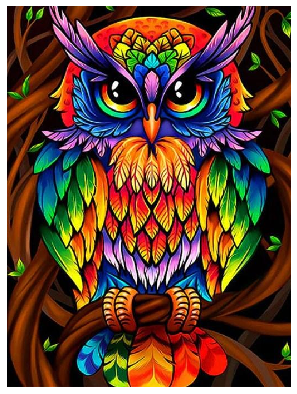

In [53]:
apply_model_to_image_raw_bytes(open("Colorful_Owl_-_PAint_by_Diamonds_540x.jpg", "rb").read())

a man laying on a rock on a beach


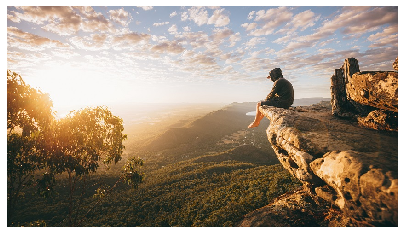

In [43]:
apply_model_to_image_raw_bytes(open("191010_nature.jpg", "rb").read())

a bird is perched on a branch in the water


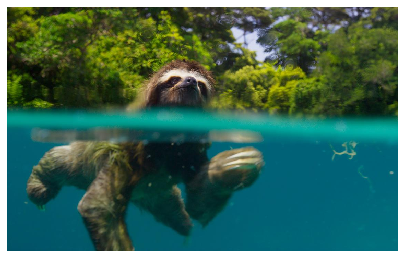

In [50]:
apply_model_to_image_raw_bytes(open("Sloth from Planet Earth II.jpg", "rb").read())

a bunch of different types of different sizes


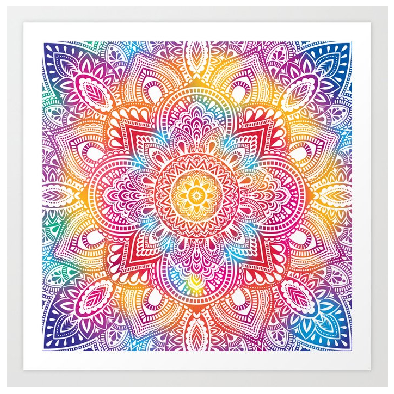

In [55]:
apply_model_to_image_raw_bytes(open("madala-ombre-colorful-prints.jpg?wait=0", "rb").read())